In [15]:
import re
import numpy as np
import pandas as pd
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [16]:
# загрузка датасета
# split train+test для бинарной классификации
dataset = load_dataset('stanfordnlp/imdb')

def to_dataframe(ds):
    return pd.DataFrame({k: ds[k] for k in ds.features.keys()})

train_df = to_dataframe(dataset['train'])
test_df = to_dataframe(dataset['test'])

In [17]:
# предобработка
nltk.download('stopwords')
stop_words = set(nltk_stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<br\s*/>", " ", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)

train_df['clean'] = train_df['text'].apply(clean_text)
train_df.dropna(subset=['clean'], inplace=True)

test_df['clean'] = test_df['text'].apply(clean_text)
test_df.dropna(subset=['clean'], inplace=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# токенизация + векторизация
vocab_size = 20000
maxlen = 200

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
(tokenizer.fit_on_texts(train_df['clean']))
X_train_seq = tokenizer.texts_to_sequences(train_df['clean'])
X_test_seq = tokenizer.texts_to_sequences(test_df['clean'])
X_train = pad_sequences(X_train_seq, maxlen=maxlen, truncating='post')
X_test = pad_sequences(X_test_seq, maxlen=maxlen, truncating='post')

y_train = train_df['label'].values
y_test = test_df['label'].values

In [19]:
# разделение train на train/val
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [20]:
# построение модели CNN
embedding_dim = 128
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling1D(pool_size=2),
    Dropout(0.6),
    Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
# компиляция модели
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
# ранняя остановка
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# обучение модели
history = model.fit(
    X_tr, y_tr,
    epochs=10, # 10 эпох не понадобятся, т.к. есть ранняя остановка
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 91s 561ms/step - accuracy: 0.5070 - loss: 0.7234 - val_accuracy: 0.8324 - val_loss: 0.3956
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 128s 470ms/step - accuracy: 0.8557 - loss: 0.3756 - val_accuracy: 0.8852 - val_loss: 0.2977
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 463ms/step - accuracy: 0.9536 - loss: 0.1644 - val_accuracy: 0.8714 - val_loss: 0.3637
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 72s 460ms/step - accuracy: 0.9795 - loss: 0.0942 - val_accuracy: 0.8754 - val_loss: 0.4722


782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step
              precision    recall  f1-score   support

           0     0.8400    0.9083    0.8728     12500
           1     0.9002    0.8270    0.8621     12500

    accuracy                         0.8677     25000
   macro avg     0.8701    0.8677    0.8675     25000
weighted avg     0.8701    0.8677    0.8675     25000



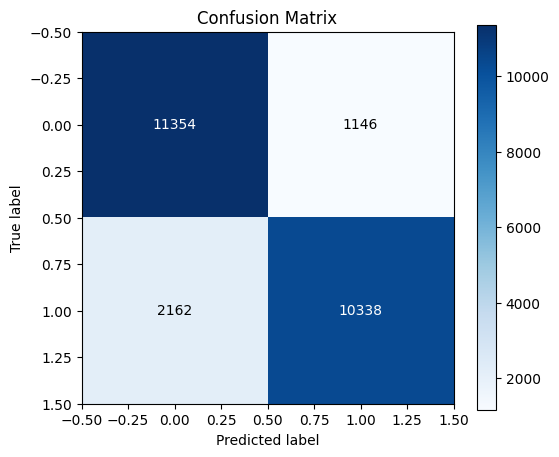

In [24]:
# оценка модели
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)

# визуализация матрицы ошибок
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Комментарии по настройке**
- параметры `vocab_size = 20000` и `maxlen = 200` будут соответсовать большинству отзывов
- `**kernel_size = 5**` захватывает как локальные, так и глобальные паттерны
- **`dropout`** нужен для борьбы с переобучением, его значение `0.6` — выбрано для более сильной регуляризации
- **L2-регуляризация** (1e-4) в сверточные и полносвязный слоях, чтобы бороться с переобучением
- использован **EarlyStopping** с `patience=2` и `restore_best_weights=True`, чтобы остановить обучение по наилучшей `val_loss`
- **количество эпох** хотя и указано `10`, но реальное число будет определено ранней остановкой

# **Результаты**
- **модель чаще правильно находит негативные отзывы** (`0 recall = 0.9083`)
- **если модель определяет позитив, то она в 90% случаев права** (но упускает ~17% реальных позитивных отзывов, т.к. `recall` ≈82.7%)
- можно утверждать о **почти сбалансированной работе модели по обеим метрикам**, т.к. `F1-score` для обоих классов близок — ~0.87